https://www.kaggle.com/c/ds2-predictive-modeling-challenge

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

plt.style.use('seaborn')

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

def my_describe(df):
    described = (df.describe(include='all').T
                   .join(pd.DataFrame({'NaNs_%':df.isna().sum()/len(df)*100, 
                                       'dtype':df.dtypes.astype(str)})))
    return described.sort_index()

def load():
    X_train = pd.read_csv('datasets/train_features.csv', index_col=0)
    X_test  = pd.read_csv('datasets/test_features.csv', index_col=0)
    y_train = pd.read_csv('datasets/train_labels.csv', index_col=0)
    y_test = None
    
    return X_train, X_test, y_train, y_test

In [2]:
feat_deats = {
    'amount_tsh' :           'Total static head (amount water available to waterpoint)',
    'date_recorded' :        'The date the row was entered',
    'funder' :               'Who funded the well',
    'gps_height' :           'Altitude of the well',
    'installer' :            'Organization that installed the well',
    'longitude' :            'GPS coordinate',
    'latitude' :             'GPS coordinate',
    'wpt_name' :             'Name of the waterpoint if there is one',
    'num_private' :          '',
    'basin' :                'Geographic water basin',
    'subvillage' :           'Geographic location',
    'region' :               'Geographic location',
    'region_code' :          'Geographic location (coded)',
    'district_code' :        'Geographic location (coded)',
    'lga' :                  'Geographic location',
    'ward' :                 'Geographic location',
    'population' :           'Population around the well',
    'public_meeting' :       'True/False',
    'recorded_by' :          'Group entering this row of data',
    'scheme_management' :    'Who operates the waterpoint',
    'scheme_name' :          'Who operates the waterpoint',
    'permit' :               'If the waterpoint is permitted',
    'construction_year' :    'Year the waterpoint was constructed',
    'extraction_type' :      'The kind of extraction the waterpoint uses',
    'extraction_type_group': 'The kind of extraction the waterpoint uses',
    'extraction_type_class': 'The kind of extraction the waterpoint uses',
    'management' :           'How the waterpoint is managed',
    'management_group' :     'How the waterpoint is managed',
    'payment' :              'What the water costs',
    'payment_type' :         'What the water costs',
    'water_quality' :        'The quality of the water',
    'quality_group' :        'The quality of the water',
    'quantity' :             'The quantity of water',
    'quantity_group' :       'The quantity of water',
    'source' :               'The source of the water',
    'source_type' :          'The source of the water',
    'source_class' :         'The source of the water',
    'waterpoint_type' :      'The kind of waterpoint',
    'waterpoint_type_group' :'The kind of waterpoint',
}

## Naive Model

In [136]:
X_train, X_test, y_train, y_test = load()
df = X_train.join(y_train)

df.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

## Beat the Naive Model

In [18]:
X_train, X_test, y_train, y_test = load()
df = X_train.join(y_train)

described = my_describe(X_train)
cols = described.loc[described['dtype'].isin(('int64', 'float64')) | 
                     (described['unique'] < 20)].index

X_train = X_train[cols]
X_test = X_test[cols]

In [19]:
pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    RobustScaler(),
    LogisticRegression(solver='lbfgs', multi_class='multinomial')
)

In [20]:
param_grid = {
    'logisticregression__class_weight': [None, 'balanced'],
}

gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring='accuracy', 
                  verbose=1, n_jobs=-1, return_train_score=True)

In [21]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   51.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   51.7s finished
C:\Users\City_Year\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\City_Year\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=None, drop_invariant=False, handle_unknown='impute',
       impute_missing=True, return_df=True, use_cat_names=True, verbose=0)), ('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('logis...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'logisticregression__class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [22]:
gs.best_params_

{'logisticregression__class_weight': None}

In [23]:
gs.best_score_

0.7216666666666667

In [ ]:
sumbission = (pd.DataFrame({'id':X_test.index, 
                            'status_group':gs.predict(X_test)}))
sumbission.to_csv('datasets/submission_01.csv', index=False)

## Engineering

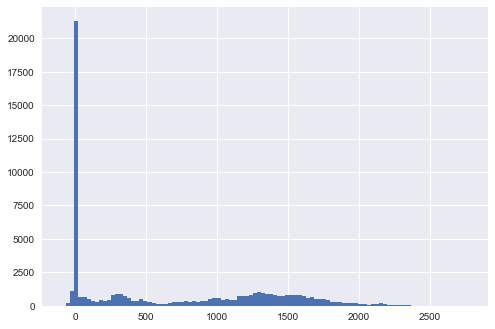

In [134]:
X_train['gps_height'].hist(bins=100);

In [34]:
def my_factorize(series):
    mapping = {'non functional':0, 
               'functional needs repair':1,
               'functional':2}
    return series.map(mapping)

In [35]:
y_train['status_group'] = my_factorize(y_train['status_group'])

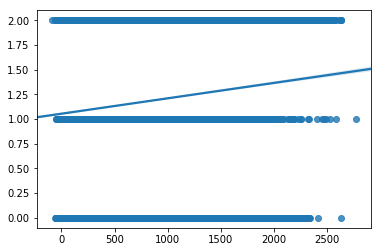

In [38]:
sns.regplot(x=X_train['gps_height'].values, y=y_train['status_group'].values); #, alpha=0.01, linewidth=0

In [ ]:
df['construction_year'].hist(bins=100);

In [13]:
df.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

In [11]:
df['installer'].value_counts()

DWE                               17402
Government                         1825
RWE                                1206
Commu                              1060
DANIDA                             1050
KKKT                                898
Hesawa                              840
0                                   777
TCRS                                707
Central government                  622
CES                                 610
Community                           553
DANID                               552
District Council                    551
HESAWA                              539
World vision                        408
LGA                                 408
WEDECO                              397
TASAF                               396
District council                    392
Gover                               383
AMREF                               329
TWESA                               316
WU                                  301
Dmdd                                287


In [15]:
reduced = df[['installer']].copy()
reduced = clean_nans(reduced)
reduced = reduce_cardinality(reduced)
reduced['installer'].value_counts()

dwe           17405
government     1891
hesawa         1395
rwe            1206
Name: installer, dtype: int64

In [61]:
def clean_nans(df):
    nan_vals = {'installer':'0',
                'funder':'0',
                'wpt_name':'none',
                'construction_year':0}
    for col in nan_vals.keys():
        if col in df:
            df[col] = df[col].replace({nan_vals.get(col, np.nan):np.nan})
        
    return df
        
def feature_engineering(df):
    # numerics converted to categories here due to NaNs and clustered distribution
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['age_years'] = (df['date_recorded'] - pd.to_datetime(df['construction_year'])).dt.days // 365
    df['age_years'] = df['age_years'].astype(str)

    df['construction_half_decade'] = df['construction_year'] // 5 * 5
    df['construction_half_decade'] = df['construction_half_decade'].astype(str)

    df['year_recorded'] = df['date_recorded'].dt.year
    df['month_recorded'] = df['date_recorded'].dt.month.astype(str)

    del df['construction_year'], df['date_recorded']

    # region_code to cat
    df['region_code'] = df['region_code'].astype(str)

    return df

def reduce_cardinality(df, max_rank=10, min_percent=0.02):
    # reduce high cardinality cols to top 10 values AND values in > 2% of dataset
    for col in df.select_dtypes(exclude=np.number):
        counts = df[col].value_counts(normalize=True)
        keep_cats = counts.loc[counts >= min_percent].index[:max_rank]
        df.loc[~df[col].isin(keep_cats), col] = np.nan

    return df

def preprocess(df, training=True, drop_cols=['num_private', 'latitude', 'longitude']):
    df = df.drop(columns=drop_cols)
    df = clean_nans(df)
    df = feature_engineering(df)

    for col in df.select_dtypes(exclude=np.number):
        df[col] = df[col].fillna('none')
        df[col] = df[col].astype(str).str.lower()
        
    if training:
        df = reduce_cardinality(df)
            
    return df

In [60]:
X_train, X_test, y_train, y_test = load()
X_train = preprocess(X_train)
X_test = preprocess(X_test, training=False)

pipe = make_pipeline(
    #OneHotEncoder(handle_unknown='ignore'),
    ce.OneHotEncoder(use_cat_names=True), 
    RobustScaler(),
    LogisticRegression(solver='lbfgs', multi_class='multinomial')
)

gs = GridSearchCV(pipe, cv=4, param_grid={}, scoring='accuracy', 
                  verbose=1, n_jobs=-1, return_train_score=True)

gs.fit(X_train, y_train)

KeyboardInterrupt: 

In [11]:
gs.best_score_

0.7331649831649831

In [12]:
sumbission = (pd.DataFrame({'id':X_test.index, 
                            'status_group':gs.predict(X_test)}))
sumbission.to_csv('datasets/submission_02.csv', index=False)

## Random Forest

In [149]:
X_train, X_test, y_train, y_test = load()
X_train = preprocess(X_train, drop_cols=['num_private'])
X_test = preprocess(X_test, drop_cols=['num_private'], training=False)
y_train = y_train['status_group']

In [ ]:
df.waterpoint_type = pd.factorize(df.waterpoint_type)[0]
df.payment_type = pd.factorize(df.payment_type)[0]
df.water_quality = pd.factorize(df.water_quality)[0]
df.scheme_management = pd.factorize(df.scheme_management)[0]

In [152]:
pipe = make_pipeline(
    # TODO factorize categories
    ce.OneHotEncoder(use_cat_names=True), 
#     RobustScaler(),
    RandomForestClassifier(n_estimators=100)
)

scores = cross_validate(pipe, X_train, y_train,  
                        cv=3, return_train_score=True, 
                        return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,45.819728,10.604537,"Pipeline(memory=None,\n steps=[('onehotenc...",0.797980,0.997273
1,44.957963,13.403268,"Pipeline(memory=None,\n steps=[('onehotenc...",0.799899,0.997551
2,50.774196,14.538163,"Pipeline(memory=None,\n steps=[('onehotenc...",0.795960,0.997121


In [21]:
pipe.fit(X_train, y_train)

array([[7.20000000e-01, 1.00000000e-01, 1.80000000e-01],
       [7.11771177e-01, 1.67243886e-01, 1.20984937e-01],
       [7.30000000e-01, 1.70000000e-01, 1.00000000e-01],
       ...,
       [8.22145026e-01, 4.30655394e-02, 1.34789434e-01],
       [5.36554380e-01, 2.93491142e-01, 1.69954478e-01],
       [3.66162257e-04, 3.30248166e-05, 9.99600813e-01]])

In [70]:
sumbission = (pd.DataFrame({'id':X_test.index,
                            'status_group':pipe.predict(X_test)}))
sumbission.to_csv('datasets/submission_03.csv', index=False)

## Mapping

In [ ]:
# find locations of basins
# dist from population clusters
# dist from basins
# dist from country center

In [ ]:
X_train, X_test, y_train, y_test = load()
df = X_train.join(y_train)

In [4]:
X_train, X_test, y_train, y_test = load()
df = X_train.join(y_train)
df = df.loc[df.longitude > 0]

In [215]:
import folium
from scipy.spatial import ConvexHull

def plot_convex_hulls(df, group_name='basin'):
    m = folium.Map(
        location=[df.latitude.mean(), df.longitude.mean()],
        zoom_start=6,
        tiles="CartoDB dark_matter"
    )

    grouped = df.groupby(group_name)

    for basin_name, df in grouped:
        points = list(zip(df.latitude, df.longitude))

        # Create the convex hull using scipy.spatial 
        hull = ConvexHull(points)
        form = [points[i] for i in hull.vertices]

        folium.Polygon(locations=form, color='lightblue', 
                       fill_color='lightskyblue', weight=2, 
                       popup=(folium.Popup(basin_name))).add_to(m)

    return m

In [216]:
plot_convex_hulls(df, group_name='basin')

In [7]:
from scipy.spatial import ConvexHull


def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371000):
    """
    Vectorized great circle distance between two points
    (lat, lon) specified in decimal degrees or in radians)
    Returns units in meters
    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


def append_dist_to_group_center(df, group_col='basin'):
    lats = {}
    lons = {}

    grouped = df.groupby(group_col)
    for group_name, group_df in grouped:
        points = list(zip(group_df.latitude, group_df.longitude))

        hull = ConvexHull(points)
        form = [points[i] for i in hull.vertices]

        lats[group_name] = np.mean(hull.points[hull.vertices,0])
        lons[group_name] = np.mean(hull.points[hull.vertices,1])
    
    centroids_df = (pd.DataFrame([lats, lons]).T
                      .rename(columns={0:f'{group_col}_lat', 1:f'{group_col}_lon'}))
    
    df = df.merge(centroids_df, left_on=group_col, right_index=True)
    
    df[f'dist_to_{group_col}'] = haversine(df.latitude, df.longitude, 
                                           df[f'{group_col}_lat'], df[f'{group_col}_lon'])
    return df

In [8]:
df = append_dist_to_group_center(df, group_col='basin')

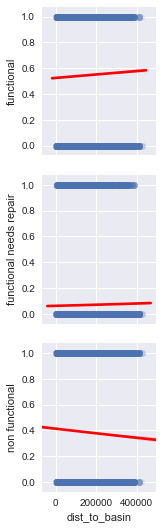

In [10]:
sns.pairplot(data=pd.get_dummies(df['status_group']).join(df['dist_to_basin']),
             x_vars='dist_to_basin', 
             y_vars=['functional', 'functional needs repair', 'non functional'],
             kind='reg',
             plot_kws={'logistic':True, 'line_kws':{'color':'red'},
                       'scatter_kws': {'alpha': 0.1}});